# Matrix Fatorization

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2023-03-28 10:07:56.509022: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 10:07:56.679411: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 10:07:58.475953: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriat

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4280380163606302493
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 48963584000
 locality {
   bus_id: 2
   numa_node: 1
   links {
   }
 }
 incarnation: 17520690506680534877
 physical_device_desc: "device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.optimizers import Adam
from keras.models import Model

### Hit Rate 계산 함수

일반적인 hit_rate 계산과는 다르게 User의 평가가 3.5이상인 Item만 Hit 판단

In [32]:
def calc_hit(model, u_id_list, data_df, top_n):
    hit_list = []
    u_id_list = np.asarray(u_id_list)
    for u_id in u_id_list:
        hit_count = 0
        p_id_list = np.asarray(list(set(data_df['p_id'][data_df['u_id']==u_id])))
        pred_df = pd.DataFrame(columns=['u_id', 'p_id', 'score'])
        for p_id in p_id_list:
            pred = model.predict([u_id, p_id])
            new_data = pd.DataFrame({'u_id': [u_id], 'p_id': [p_id], 'score': [pred]})
            pred_df = pd.concat([pred_df, new_data], axis=0, names=['u_id', 'p_id', 'rating'], ignore_index=True)
            recom_df = pred_df.sort_values(by=['score'], ascending=False)[:top_n]
            actual_df = data_df[data_df.u_id == u_id].sort_values(by=['score'], ascending=False)
            actual_df = actual_df[actual_df.score>=3.5][:top_n]
            
            
        for item in set(recom_df['p_id']):
            if int(item) in list(set(actual_df['p_id'])):
                hit_count += 1
                    
        hit_list.append(hit_count/top_n)
    return sum(hit_list)/len(u_id_list)

### 데이터 테이블 생성

In [4]:
table_df = pd.read_csv('../data/ulsan_rest_table_ver3.csv')
table_df

,p_id,place_id,u_id,user_id,score,comment
0,0,225토마토스트릿,24506,힘내라힘,2,분위기에 비해 맛은 쏘쏘...
1,0,225토마토스트릿,24493,히둥이,5,NaN
2,0,225토마토스트릿,24328,황영하,5,파스타 너무 맛있게 잘 먹었어요 태화동에 맛집이 별로 없어서 아쉬웠는데 맛집을 발견...
3,0,225토마토스트릿,24247,황규현,5,스테이크 부위가 바뀐것같은데 바뀐고기가 훨씬 좋은것 같아요..!.!!! 육향도 좋고...
4,0,225토마토스트릿,24022,호두과자,5,NaN
...,...,...,...,...,...,...
54495,491,효정밥상,497,bbui bbui,4,가성비 좋은 간장게장 집. 비록 가격이 꾸준히 상승하고있긴 하지만 부담스럽진 않은 ...
54496,491,효정밥상,447,b suwan,5,가성비최고 간정게장집이라고 생각해요. 게장 직접담구는 모습도 볼수있고 직접담그는 만...
54497,491,효정밥상,328,Alex Ha,5,가성비는 대박입니다. 솔직히 맛도 좋음. (간장게장 기준)\n\n좀만 더 깨끗한 ...
54498,491,효정밥상,149,0o0o,5,여긴 진짜 간장게장에 진리다 사장님 이제 포장 안해주셔요 참고하세요 진짜 jmt


In [5]:
print(table_df.isnull().sum())
table_df.drop(columns='comment', inplace=True)
table_df.dropna(axis=0, how='any', inplace=True)

p_id            0
place_id        0
u_id            0
user_id         0
score           0
comment     14275
dtype: int64


In [6]:
table_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54500 entries, 0 to 54499
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   p_id      54500 non-null  int64 
 1   place_id  54500 non-null  object
 2   u_id      54500 non-null  int64 
 3   user_id   54500 non-null  object
 4   score     54500 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.1+ MB


In [7]:
data_df = table_df[['u_id', 'p_id', 'score']]
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54500 entries, 0 to 54499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   u_id    54500 non-null  int64
 1   p_id    54500 non-null  int64
 2   score   54500 non-null  int64
dtypes: int64(3)
memory usage: 1.2 MB


### Train, Test split

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_df, test_size=0.2, random_state=42)

In [9]:
n_users = data_df.u_id.unique().shape[0]
n_places = data_df.p_id.unique().shape[0]
print(n_users, n_places)

24545 492


In [10]:
n_users = data_df.u_id.max()
n_places = data_df.p_id.max()
print(n_users, n_places)

24544 491


In [11]:
tf.keras.backend.clear_session()

### callback

In [12]:
earlystopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

### Model

In [13]:
latent_dim = 100 ## 잠재요인

# creating book embedding path
place_input = Input(shape=[1], name="Place-Input")
place_embedding = Embedding(n_places+1, latent_dim, name="Place-Embedding")(place_input)
place_vec = Flatten(name="Flatten-Places")(place_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1,latent_dim, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([place_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(256, activation='relu')(conc)
fc2 = Dense(128, activation='relu')(fc1)
fc3 = Dense(128, activation='relu')(fc2)
out = Dense(1)(fc3)

# Create model and compile it
model = Model([user_input, place_input], out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), loss='mean_squared_error')

2023-03-28 10:08:01.368710: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46695 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:af:00.0, compute capability: 8.6


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Place-Input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Place-Embedding (Embedding)    (None, 1, 100)       49200       ['Place-Input[0][0]']            
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 100)       2454500     ['User-Input[0][0]']             
                                                                                              

### Model Trainning

In [15]:
history = model.fit(x=[np.array(train.u_id), np.array(train.p_id)],y= np.array(train.score), validation_split=0.2, epochs=100, verbose=1, callbacks=[earlystopping])

Epoch 1/100


2023-03-28 10:08:04.695134: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-03-28 10:08:04.878215: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f706b73a210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-28 10:08:04.878250: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2023-03-28 10:08:04.891817: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-28 10:08:05.136955: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1090/1090 [==============================] - 13s 8ms/step - loss: 1.4271 - val_loss: 1.1975
Epoch 2/100
1090/1090 [==============================] - 7s 7ms/step - loss: 0.8849 - val_loss: 1.2864
Epoch 3/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.7212 - val_loss: 1.2978
Epoch 4/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.6503 - val_loss: 1.3575
Epoch 5/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.5821 - val_loss: 1.3458
Epoch 6/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.5310 - val_loss: 1.3281
Epoch 7/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.4676 - val_loss: 1.3976
Epoch 8/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.4035 - val_loss: 1.3812
Epoch 9/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.3311 - val_loss: 1.3370
Epoch 10/100
1090/1090 [==============================] - 7s 6ms/step - loss: 0.2781

### Loss graph

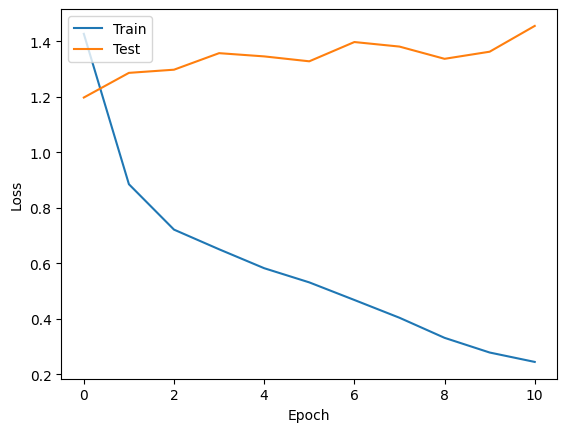

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
plt.show()

In [17]:
model.evaluate([test.u_id, test.p_id], test.score)

341/341 [==============================] - 1s 3ms/step - loss: 1.4989


1.4988718032836914

In [18]:
from sklearn.metrics import mean_squared_error
y_prob = model.predict([test.u_id, test.p_id])
y_true = test.score
mean_squared_error(y_true, np.round(y_prob))**0.5

341/341 [==============================] - 1s 2ms/step


1.268893905383451

### 성능평가(RMSE)

In [19]:
model.save("./model/MF.h5")
loaded_model = tf.keras.models.load_model("./model/MF.h5")

In [121]:
uid_list = [10556, 53, 13875, 8349, 5484, 9601, 6823, 16187, 4422, 12681]
uid_list = np.array(uid_list)

In [124]:
def calc_hit(model, uid_list, data_df, top_n):
    hit = []
    # pid_list = np.array(data_df.p_id.unique())
    for u_id in uid_list:
        p_id_list = np.array(list(set(data_df['p_id'][data_df['u_id']==u_id])))
        pred_df = pd.DataFrame(columns=['u_id', 'p_id', 'score'])
        for p_id in p_id_list:
            pred = model.predict([np.array([u_id]), np.array([p_id])])
            new_data = pd.DataFrame({'u_id': [u_id], 'p_id': [p_id], 'score': [pred]})
            pred_df = pd.concat([pred_df, new_data], axis=0, names=['u_id', 'p_id', 'rating'], ignore_index=True)
            recom_df = pred_df.sort_values(by=['score'], ascending=False)[:top_n]
            actual_df = data_df[data_df.u_id == u_id].sort_values(by=['score'], ascending=False)
            actual_df = actual_df[actual_df.score>=3.5][:top_n]
            
        for item in set(recom_df['p_id']):
            if int(item) in list(set(actual_df['p_id'])):
                hit.append(1)
            else:
                hit.append(0)
    return np.mean(hit)

In [125]:
hit_rate = calc_hit(loaded_model, uid_list, data_df, 10)

1/1 [==============================] - 0s 28ms/step


In [126]:
hit_rate

0.34